# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [ ]:
import numpy as np
from scipy import misc
from imp import reload
# from labfuns import *
import random
import math

In [ ]:
from __future__ import absolute_import, division, print_function
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ColorConverter
import random as rnd
from sklearn.datasets import make_blobs
from sklearn import decomposition, tree

# import seaborn as sns
# sns.set()

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ellip.set_alpha(0.25)

    ax.add_artist(ellip)
    return ellip


# Splits data into training and test set, pcSplit defines the percent of
# the data should be used as training data.
def trteSplit(X,y,pcSplit,seed=None):
    # Compute split indices
    Ndata = X.shape[0]
    Ntr = int(np.rint(Ndata*pcSplit))
    Nte = Ndata-Ntr
    np.random.seed(seed)    
    idx = np.random.permutation(Ndata)
    trIdx = idx[:Ntr]
    teIdx = idx[Ntr:]
    # Split data
    xTr = X[trIdx,:]
    yTr = y[trIdx]
    xTe = X[teIdx,:]
    yTe = y[teIdx]
    return xTr,yTr,xTe,yTe,trIdx,teIdx


# Splits data into training and test set, pcSplit defines the percent of
# the data should be used as training data. The major difference to
# trteSplit is that we select the percent from each class individually.
# This means that we are assured to have enough points for each class.
def trteSplitEven(X,y,pcSplit,seed=None):
    labels = np.unique(y)
    xTr = np.zeros((0,X.shape[1]))
    xTe = np.zeros((0,X.shape[1]))
    yTe = np.zeros((0,),dtype=int)
    yTr = np.zeros((0,),dtype=int)
    trIdx = np.zeros((0,),dtype=int)
    teIdx = np.zeros((0,),dtype=int)
    np.random.seed(seed)
    for label in labels:
        classIdx = np.where(y==label)[0]
        NPerClass = len(classIdx)
        Ntr = int(np.rint(NPerClass*pcSplit))
        idx = np.random.permutation(NPerClass)
        trClIdx = classIdx[idx[:Ntr]]
        teClIdx = classIdx[idx[Ntr:]]
        trIdx = np.hstack((trIdx,trClIdx))
        teIdx = np.hstack((teIdx,teClIdx))
        # Split data
        xTr = np.vstack((xTr,X[trClIdx,:]))
        yTr = np.hstack((yTr,y[trClIdx]))
        xTe = np.vstack((xTe,X[teClIdx,:]))
        yTe = np.hstack((yTe,y[teClIdx]))

    return xTr,yTr,xTe,yTe,trIdx,teIdx


def fetchDataset(dataset='iris'):
    if dataset == 'iris':
        X = genfromtxt('/content/drive/MyDrive/irisX.txt', delimiter=',')
        y = genfromtxt('/content/drive/MyDrive/irisY.txt', delimiter=',',dtype=np.int)-1
        pcadim = 2
    elif dataset == 'wine':
        X = genfromtxt('wineX.txt', delimiter=',')
        y = genfromtxt('wineY.txt', delimiter=',',dtype=np.int)-1
        pcadim = 0
    elif dataset == 'olivetti':
        X = genfromtxt('/content/drive/MyDrive/olivettifacesX.txt', delimiter=',')
        X = X/255
        y = genfromtxt('/content/drive/MyDrive/olivettifacesY.txt', delimiter=',',dtype=np.int)
        pcadim = 20
    elif dataset == 'vowel':
        X = genfromtxt('/content/drive/MyDrive/vowelX.txt', delimiter=',')
        y = genfromtxt('/content/drive/MyDrive/vowelY.txt', delimiter=',',dtype=np.int)
        pcadim = 0
    else:
        print("Please specify a dataset!")
        X = np.zeros(0)
        y = np.zeros(0)
        pcadim = 0

    return X,y,pcadim


def genBlobs(n_samples=200,centers=5,n_features=2):
    X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features,random_state=0)
    return X,y


# Scatter plots the two first dimension of the given data matrix X
# and colors the points by the labels.
def scatter2D(X,y):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = np.where(y==label)[0]
        Xclass = X[classIdx,:]
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=25,color=colors[label],marker='o',alpha=0.75)
        c += 1.

    plt.show()


def plotGaussian(X,y,mu,sigma):
    labels = np.unique(y)
    Ncolors = len(labels)
    xx = np.arange(Ncolors)
    ys = [i+xx+(i*xx)**2 for i in range(Ncolors)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    c = 1.0
    for label in labels:
        classIdx = y==label
        Xclass = X[classIdx,:]
        plot_cov_ellipse(sigma[label], mu[label])
        plt.scatter(Xclass[:,0],Xclass[:,1],linewidths=1,s=25,color=colors[label],marker='o',alpha=0.75)
        c += 1.

    plt.show()


# The function below, `testClassifier`, will be used to try out the different datasets.
# `fetchDataset` can be provided with any of the dataset arguments `wine`, `iris`, `olivetti` and `vowel`.
# Observe that we split the data into a **training** and a **testing** set.
def testClassifier(classifier, dataset='iris', dim=0, split=0.7, ntrials=100):

    X,y,pcadim = fetchDataset(dataset)

    means = np.zeros(ntrials,);

    for trial in range(ntrials):

        xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split,trial)

        # Do PCA replace default value if user provides it
        if dim > 0:
            pcadim = dim

        if pcadim > 0:
            pca = decomposition.PCA(n_components=pcadim)
            pca.fit(xTr)
            xTr = pca.transform(xTr)
            xTe = pca.transform(xTe)

        # Train
        trained_classifier = classifier.trainClassifier(xTr, yTr)
        # Predict
        yPr = trained_classifier.classify(xTe)

        # Compute classification error
        if trial % 10 == 0:
            print("Trial:",trial,"Accuracy","%.3g" % (100*np.mean((yPr==yTe).astype(float))) )

        means[trial] = 100*np.mean((yPr==yTe).astype(float))

    print("Final mean classification accuracy ", "%.3g" % (np.mean(means)), "with standard deviation", "%.3g" % (np.std(means)))


# ## Plotting the decision boundary
#
# This is some code that you can use for plotting the decision boundary
# boundary in the last part of the lab.
def plotBoundary(classifier, dataset='iris', split=0.7):

    X,y,pcadim = fetchDataset(dataset)
    xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split,1)
    classes = np.unique(y)

    pca = decomposition.PCA(n_components=2)
    pca.fit(xTr)

    xTr = pca.transform(xTr)
    xTe = pca.transform(xTe)

    pX = np.vstack((xTr, xTe))
    py = np.hstack((yTr, yTe))

    # Train
    trained_classifier = classifier.trainClassifier(xTr, yTr)

    xRange = np.arange(np.min(pX[:,0]),np.max(pX[:,0]),np.abs(np.max(pX[:,0])-np.min(pX[:,0]))/100.0)
    yRange = np.arange(np.min(pX[:,1]),np.max(pX[:,1]),np.abs(np.max(pX[:,1])-np.min(pX[:,1]))/100.0)

    grid = np.zeros((yRange.size, xRange.size))

    for (xi, xx) in enumerate(xRange):
        for (yi, yy) in enumerate(yRange):
            # Predict
            grid[yi,xi] = trained_classifier.classify(np.array([[xx, yy]]))

    
    ys = [i+xx+(i*xx)**2 for i in range(len(classes))]
    colormap = cm.rainbow(np.linspace(0, 1, len(ys)))

    fig = plt.figure()
    # plt.hold(True)
    conv = ColorConverter()
    for (color, c) in zip(colormap, classes):
        try:
            CS = plt.contour(xRange,yRange,(grid==c).astype(float),15,linewidths=0.25,colors=conv.to_rgba_array(color))
        except ValueError:
            pass
        trClIdx = np.where(y[trIdx] == c)[0]
        teClIdx = np.where(y[teIdx] == c)[0]
        plt.scatter(xTr[trClIdx,0],xTr[trClIdx,1],marker='o',c=color,s=40,alpha=0.5, label="Class "+str(c)+" Train")
        plt.scatter(xTe[teClIdx,0],xTe[teClIdx,1],marker='*',c=color,s=50,alpha=0.8, label="Class "+str(c)+" Test")
    plt.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    fig.subplots_adjust(right=0.7)
    plt.show()


def visualizeOlivettiVectors(xTr, Xte):
    N = xTr.shape[0]
    Xte = Xte.reshape(64, 64).transpose()
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Test image")
    plt.imshow(Xte, cmap=plt.get_cmap('gray'))
    for i in range(0, N):
        plt.subplot(N, 2, 2+2*i)
        plt.xticks([])
        plt.yticks([])
        plt.title("Matched class training image %i" % (i+1))
        X = xTr[i, :].reshape(64, 64).transpose()
        plt.imshow(X, cmap=plt.get_cmap('gray'))
    plt.show()


class DecisionTreeClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, Xtr, yTr, W=None):
        rtn = DecisionTreeClassifier()
        rtn.classifier = tree.DecisionTreeClassifier(max_depth=Xtr.shape[1]/2+1)
        if W is None:
            rtn.classifier.fit(Xtr, yTr)
        else:
            rtn.classifier.fit(Xtr, yTr, sample_weight=W.flatten())
        rtn.trained = True
        return rtn

    def classify(self, X):
        return self.classifier.predict(X)


## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy.matrixlib.defmatrix import N
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    # TODO: compute the values of prior for each class!
    # ==========================
    '''
    prior = (np.unique(labels, return_counts=True)[1]/Npts).reshape(-1, 1)
    '''
    for j, c in enumerate(classes):
      i = np.where(labels == c)[0]
      w = W[i]
      prior[j] = np.sum(w) / np.sum(W)
    # ==========================

    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    # for jdx, c in enumerate(classes):
    #   idx = np.where(labels == c)[0]
    #   xi = X[idx,:]
    #   mu[jdx] = np.mean(xi, axis=0)
    #   t = xi - mu[jdx]
    #   sigma[jdx] = np.diag(np.diag(np.dot(t.transpose(), t)/xi.shape[0]))
   
    for j, c in enumerate(classes):
      i = np.where(labels == c)[0]
      xi = np.dot(W[i].T, X[i,:])
      mu[j] = xi / np.sum(W[i])
      t = np.sqrt(W[i]) * (X[i,:] - mu[j])
      sigma[j] = np.diag(np.diag(np.dot(t.transpose(), t)/np.sum(W[i])))
    
    # ==========================

    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    
    for i in range(Nclasses):
      for j in range(len(X)):
        logProb[i, j] = -0.5*np.log(np.linalg.det(sigma[i])) \
                        -0.5*np.dot((X[j]-mu[i]), np.dot(np.diag(1.0 / np.diag(sigma[i])), (X[j]-mu[i]).T)) \
                        + np.log(prior[i])
    
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [ ]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

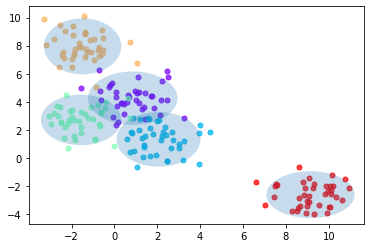

In [ ]:
%matplotlib inline
X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [ ]:
# np.seterr(divide = 'ignore') 
testClassifier(BayesClassifier(), dataset='iris', split=0.7)
# np.seterr(divide = 'warn') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [ ]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


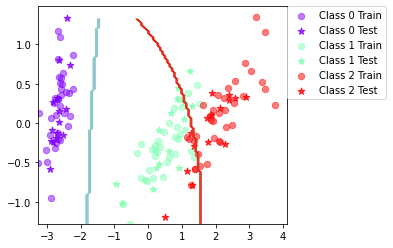

In [ ]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Boosting functions to implement

The lab descriptions state what each function should do.

In [ ]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================  
        error = 1e-15
        for i in range(Npts):
          if vote[i] != labels[i]:
            error += wCur[i] 
        alpha = 0.5 * (np.log(1-error)-np.log(error))
        
        for i in range(Npts):
          if vote[i] == labels[i]:
            wCur[i] *= np.exp(-alpha)
          else:
            wCur[i] *= np.exp(alpha)

        wCur /= np.sum(wCur)

        alphas.append(alpha) 
        
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        for t in range(Ncomps):
          vote_t = classifiers[t].classify(X)
          for x, v in enumerate(vote_t):
            votes[x, v] += alphas[t]
        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [ ]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.7 with standard deviation 2.82


In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 79.9
Trial: 90 Accuracy 83.1
Final mean classification accuracy  80.2 with standard deviation 3.52


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


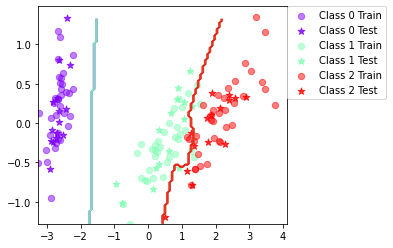

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.67


In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 87
Trial: 10 Accuracy 89.6
Trial: 20 Accuracy 86.4
Trial: 30 Accuracy 91.6
Trial: 40 Accuracy 80.5
Trial: 50 Accuracy 81.8
Trial: 60 Accuracy 89
Trial: 70 Accuracy 87.7
Trial: 80 Accuracy 84.4
Trial: 90 Accuracy 85.7
Final mean classification accuracy  86.5 with standard deviation 2.95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


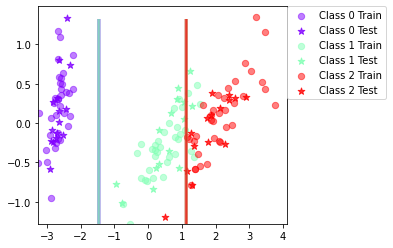

In [ ]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


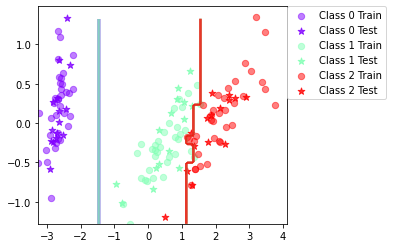

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 85
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 80
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.5 with standard deviation 3.12


In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='olivetti',split=0.7, dim=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 65.8
Trial: 10 Accuracy 57.5
Trial: 20 Accuracy 49.2
Trial: 30 Accuracy 50
Trial: 40 Accuracy 53.3
Trial: 50 Accuracy 44.2
Trial: 60 Accuracy 49.2
Trial: 70 Accuracy 54.2
Trial: 80 Accuracy 50
Trial: 90 Accuracy 52.5
Final mean classification accuracy  48.4 with standard deviation 6.45


In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Trial: 0 Accuracy 74.2
Trial: 10 Accuracy 71.7
Trial: 20 Accuracy 76.7
Trial: 30 Accuracy 73.3
Trial: 40 Accuracy 74.2
Trial: 50 Accuracy 66.7
Trial: 60 Accuracy 72.5
Trial: 70 Accuracy 63.3
Trial: 80 Accuracy 65.8
Trial: 90 Accuracy 70.8
Final mean classification accuracy  70.7 with standard deviation 6.73


You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


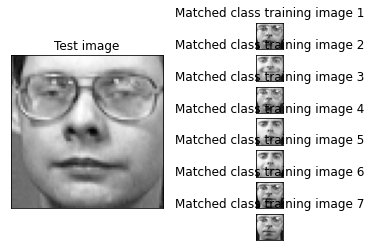

In [ ]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])